In [1]:
from utils import get_paper_ref
from operator import itemgetter
from collections import Counter
# import sys
# !{sys.executable} -m pip install sklearn
# !{sys.executable} -m pip install numpy
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

/Users/minjeongshin/miniconda2/lib/python2.7/site-packages/scipy/sparse/lil.py:19: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _csparsetools
/Users/minjeongshin/miniconda2/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:165: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._shortest_path import shortest_path, floyd_warshall, dijkstra,\
/Users/minjeongshin/miniconda2/lib/python2.7/site-packages/scipy/sparse/csgraph/_validation.py:5: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._tools import csgraph_to_dense, csgraph_from_dense,\
/Users/minjeongshin/miniconda2/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:167: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._traversal import breadth_first_order, depth_first_order, 

In [2]:
name_id_pairs = {
    "steve_blackburn": {"id": 2146610949, "type":"author"},
    "kathryn_mckinley": {"id": 2115847858, "type":"author"},
#     "james_bornholt": {"id": 2026265091, "type":"author"},
#     "julian_dolby": {"id": 2780161863, "type":"author"},
#     "perry_cheng": {"id": 2140441920, "type":"author"},
    "julian_mcauley": {"id": 2041520510, "type":"author"},
    "icwsm": {"id": 1124713781, "type":"conf"},
    "popl": {"id": 1160032607, "type":"conf"},
    "pldi": {"id": 1127352206, "type":"conf"},
    "wsdm": {"id": 1120384002, "type":"conf"},
}

def get_bov(name):
    res = get_paper_ref(name_id_pairs[name]["id"], name_id_pairs[name]["type"])
#     print(res)
    name_id_pairs[name]["numpaper"] = len(res)
    return get_set_of_venues_by_year(res)

def get_set_of_venues_by_year(res):
    references = []
    for p, r in res.items():
        if "References" in r and "Year" in r:
            references.append((r["Year"], r["References"]))
    venues = {}
    for y, ref in references:
        if y not in venues:
            venues[y] = []
        venues[y].extend(ref)
    return venues

def aggr_venues(data):
    venues = []
    for y, ref in data.items():
        venues.extend(ref)
    return venues

def get_vector(name, bov, author_venue, norm=False):
    c = Counter(author_venue)
    author_arr = [[float(c[b]) for b in bov]]
    if norm:
        return np.array(author_arr)/name_id_pairs[name]["numpaper"]
    else:
        return np.array(author_arr)

In [3]:
data = {}
for name in name_id_pairs.keys():
    data[name] = get_bov(name)

In [4]:
bag_of_venues = set()
sorted_list_bov = list()
for name, y_venues in data.items():
    venues = aggr_venues(y_venues)
    print("{}: len(papers)={}, len(venues)={}, len(set(venues))={}".format(name, name_id_pairs[name]["numpaper"], len(venues), len(set(venues))))
    [bag_of_venues.add(v) for v in venues]
print("Total # of venues = ", len(bag_of_venues))
sorted_list_bov = list(bag_of_venues)
number_of_venues = len(sorted_list_bov)

steve_blackburn: len(papers)=70, len(venues)=1138, len(set(venues))=133
icwsm: len(papers)=1031, len(venues)=8379, len(set(venues))=1215
julian_mcauley: len(papers)=61, len(venues)=1231, len(set(venues))=227
popl: len(papers)=1648, len(venues)=7826, len(set(venues))=565
wsdm: len(papers)=865, len(venues)=9046, len(set(venues))=942
pldi: len(papers)=1386, len(venues)=8218, len(set(venues))=621
kathryn_mckinley: len(papers)=214, len(venues)=4059, len(set(venues))=350
('Total # of venues = ', 2282)


In [5]:
vec = {}
avg_vec = {}
for name, y_venues in data.items():
    vec[name] = get_vector(name, sorted_list_bov, aggr_venues(y_venues))
    avg_vec[name] = get_vector(name, sorted_list_bov, aggr_venues(y_venues), True)

# Cosine similarity

In [59]:
print(cosine_similarity(vec["steve_blackburn"], vec["kathryn_mckinley"]))
print(cosine_similarity(avg_vec["steve_blackburn"], avg_vec["kathryn_mckinley"]))

[[0.96309839]]
[[0.96309839]]


In [42]:
print(cosine_similarity(vec["steve_blackburn"], vec["pldi"]))
print(cosine_similarity(vec["steve_blackburn"], vec["popl"]))
print(cosine_similarity(vec["steve_blackburn"], vec["wsdm"]))
print(cosine_similarity(vec["steve_blackburn"], vec["icwsm"]))

[[0.95356132]]
[[0.81350728]]
[[0.02583951]]
[[0.02185857]]


In [43]:
print(cosine_similarity(vec["kathryn_mckinley"], vec["pldi"]))
print(cosine_similarity(vec["kathryn_mckinley"], vec["popl"]))
print(cosine_similarity(vec["kathryn_mckinley"], vec["wsdm"]))
print(cosine_similarity(vec["kathryn_mckinley"], vec["icwsm"]))

[[0.95233372]]
[[0.80777307]]
[[0.04705995]]
[[0.0272073]]


In [44]:
print(cosine_similarity(vec["julian_mcauley"], vec["pldi"]))
print(cosine_similarity(vec["julian_mcauley"], vec["popl"]))
print(cosine_similarity(vec["julian_mcauley"], vec["wsdm"]))
print(cosine_similarity(vec["julian_mcauley"], vec["icwsm"]))

[[0.02087361]]
[[0.03269004]]
[[0.62136168]]
[[0.36794679]]


In [8]:
pca = PCA(n_components=2)
def plot_pca(vec):
    X = np.zeros((len(vec),number_of_venues))
    for i, v in enumerate(vec.values()):
        X[i] = v
    # print(X)

    pca.fit(X)
    X_pca = pca.transform(X)
    print("original shape:   ", X.shape)
    print("transformed shape:", X_pca.shape)
    z = X_pca[:, 0]
    y = X_pca[:, 1]
    plt.scatter(z, y)
    plt.axis('equal');
    for i, name in enumerate(data.keys()):
        plt.annotate(name, (z[i],y[i]))

In [62]:
tsne = TSNE(n_components=2, perplexity=10)
def plot_tsne(vec):
    X = np.zeros((len(vec),number_of_venues))
    for i, v in enumerate(vec.values()):
        X[i] = v
    # print(X)

    X_tsne = tsne.fit_transform(X)
    print("original shape:   ", X.shape)
    print("transformed shape:", X_tsne.shape)
    z = X_tsne[:, 0]
    y = X_tsne[:, 1]
    plt.scatter(z, y)
    plt.axis('equal');
    for i, name in enumerate(data.keys()):
        plt.annotate(name, (z[i],y[i]))

# PCA vs TSNE plot sum vectors

('original shape:   ', (7, 2282))
('transformed shape:', (7, 2))


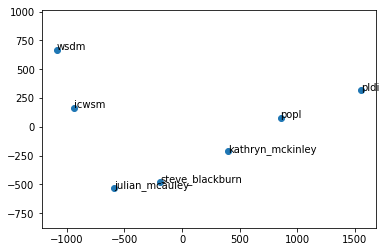

In [14]:
plot_pca(vec)

('original shape:   ', (7, 2282))
('transformed shape:', (7, 2))


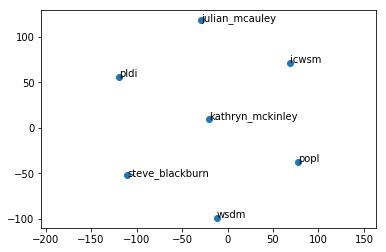

In [63]:
plot_tsne(vec)

# PCA vs TSNE plot avg vectors

('original shape:   ', (7, 2282))
('transformed shape:', (7, 2))


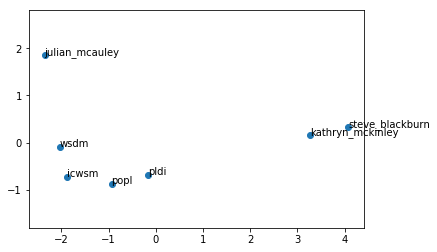

In [16]:
plot_pca(avg_vec)

('original shape:   ', (7, 2282))
('transformed shape:', (7, 2))


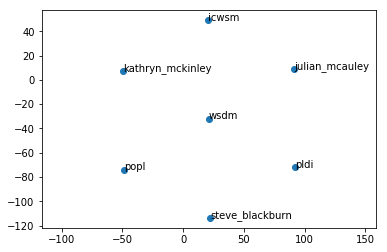

In [18]:
plot_tsne(avg_vec)

In [88]:
cmap = plt.get_cmap("tab10")

def aggr_vector(data, bins):
    venues = {}
    for y in data.keys():
        venues[y - y%bins] = []
    print(venues.keys())
    for y, ref in data.items():
        venues[y - y%bins].extend(ref)
    return venues

def year_plot(namelist, bins, normalize, method):
    plt.figure(figsize=(16,10))
    for idx, name in enumerate(namelist):
        pick = aggr_vector(data[name], bins)
        print((len(pick), number_of_venues))
        X = np.zeros((len(pick), number_of_venues))
        for i, v in enumerate(pick.values()):
            X[i] = get_vector(name, bag_of_venues, v, normalize)

        if method == "PCA":
            X_pca = pca.fit_transform(X)
        if method == "TSNE":
            X_pca = tsne.fit_transform(X)
#         print("original shape:   ", X.shape)
#         print("transformed shape:", X_pca.shape)
    
        z = X_pca[:, 0]
        y = X_pca[:, 1]
        plt.scatter(z, y, color=cmap(idx))
        plt.axis('equal');
        for i, name in enumerate(pick.keys()):
            plt.annotate(name, (z[i],y[i]))
    plt.legend(namelist, loc='upper right')

# Year plot

[2016, 2017, 2018, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
(11, 2282)
[2016, 2017, 2018, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
(13, 2282)


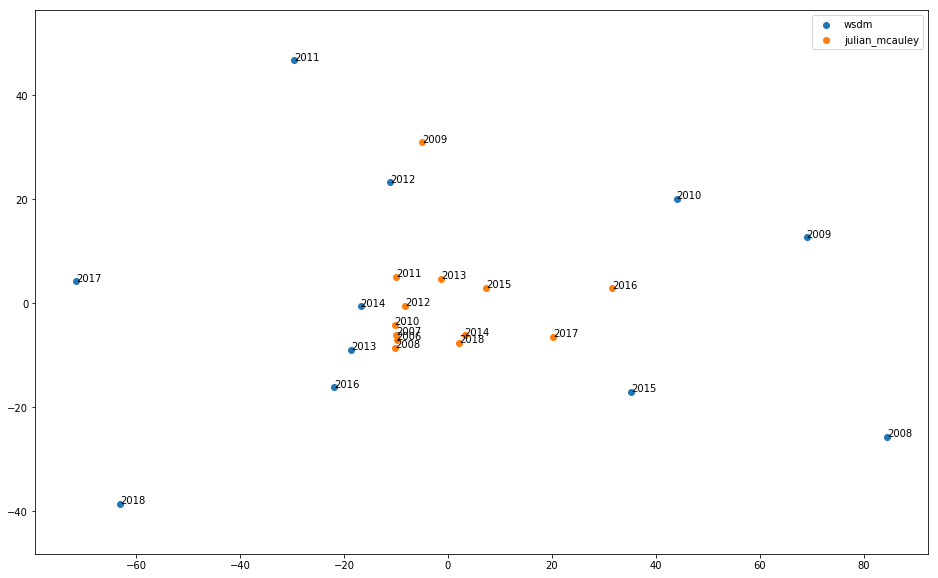

In [24]:
year_plot(["wsdm", "julian_mcauley"], 1, False, "PCA")

[2016, 2017, 2018, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
(11, 2282)
[2016, 2017, 2018, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
(13, 2282)


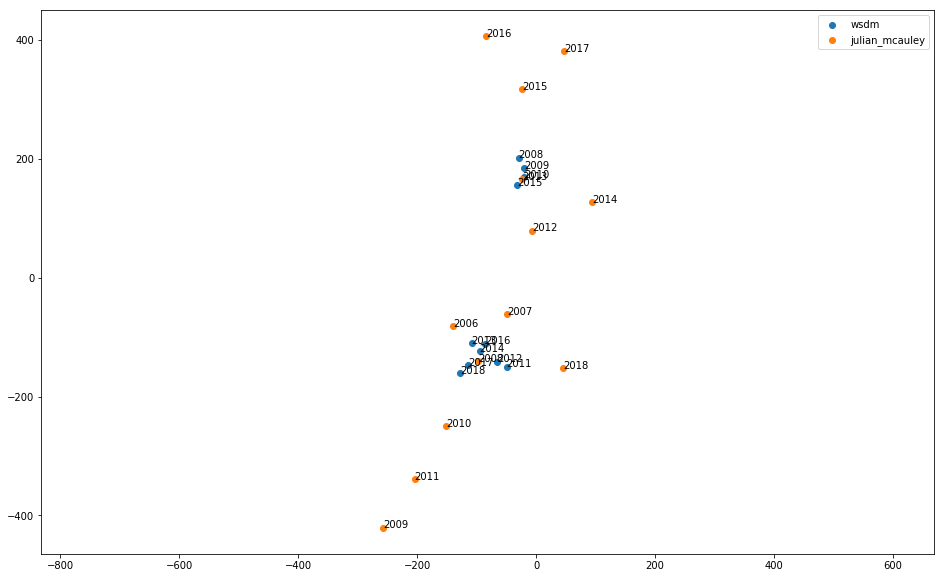

In [92]:
tsne = TSNE(n_components=2, perplexity=2)
year_plot(["wsdm", "julian_mcauley"], 1, False, "TSNE")

[2016, 2017, 2018, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
(11, 2282)
[2016, 2017, 2018, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
(13, 2282)


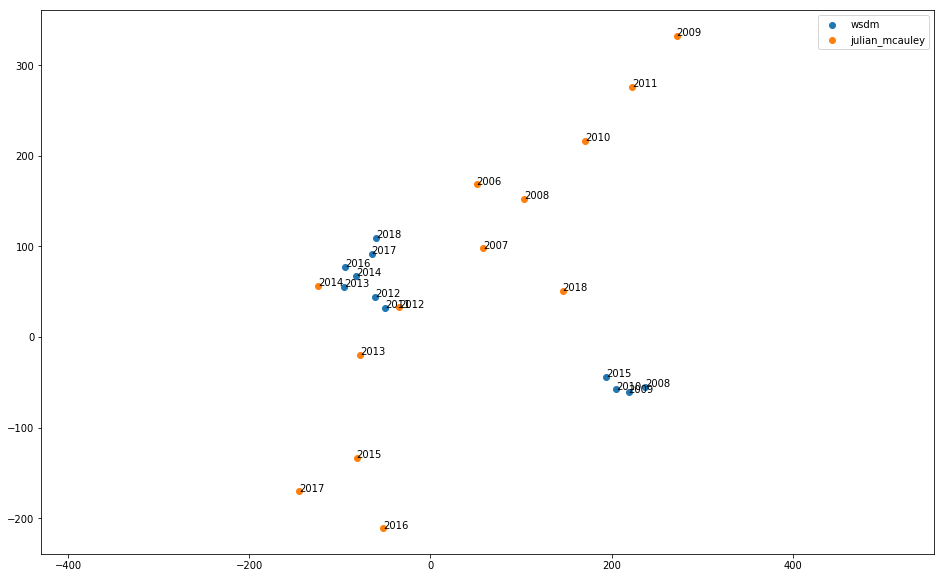

In [94]:
tsne = TSNE(n_components=2, perplexity=2)
year_plot(["wsdm", "julian_mcauley"], 1, True, "TSNE")

[2016, 2017, 2018, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
(11, 2282)
[1979, 1982, 1984, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
(36, 2282)
[2016, 2017, 2018, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
(13, 2282)


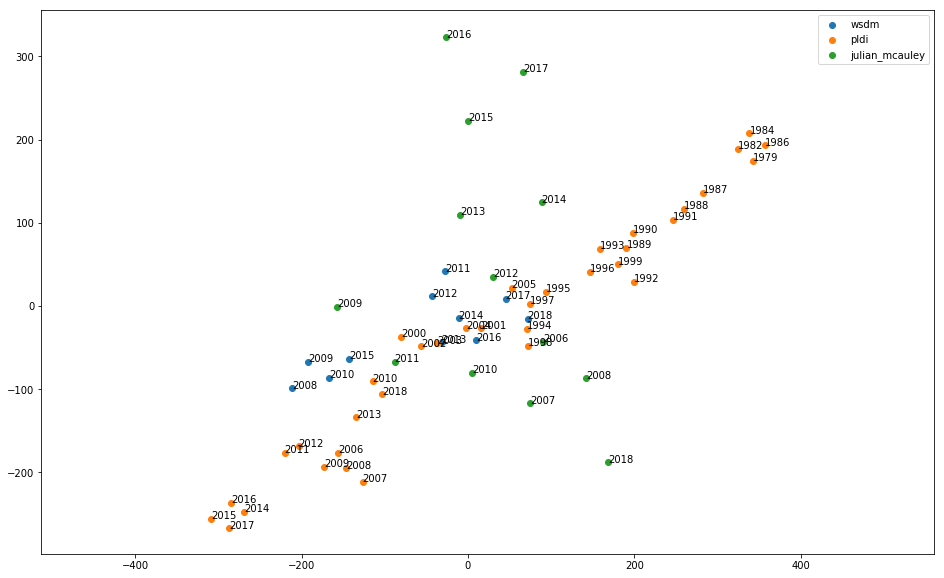

In [102]:
tsne = TSNE(n_components=2, perplexity=4)
year_plot(["wsdm", "pldi", "julian_mcauley"], 1, True, "TSNE")

[2016, 2017, 2018, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
(11, 2282)
[1979, 1982, 1984, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
(36, 2282)
[2016, 2017, 2018, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
(13, 2282)


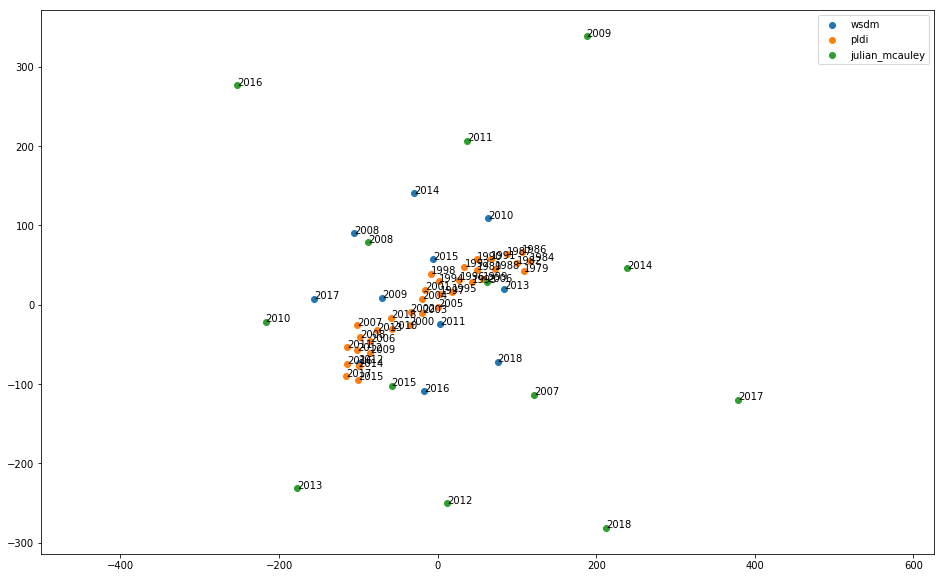

In [135]:
tsne = TSNE(n_components=2, perplexity=10)
year_plot(["wsdm", "pldi", "julian_mcauley"], 1, False, "TSNE")

[2016, 2010, 2013, 2007]
(4, 2282)
[2016, 1986, 1989, 1992, 1995, 1998, 2001, 2004, 2007, 1977, 2010, 1980, 2013, 1983]
(14, 2282)
[2016, 2010, 2004, 2013, 2007]
(5, 2282)


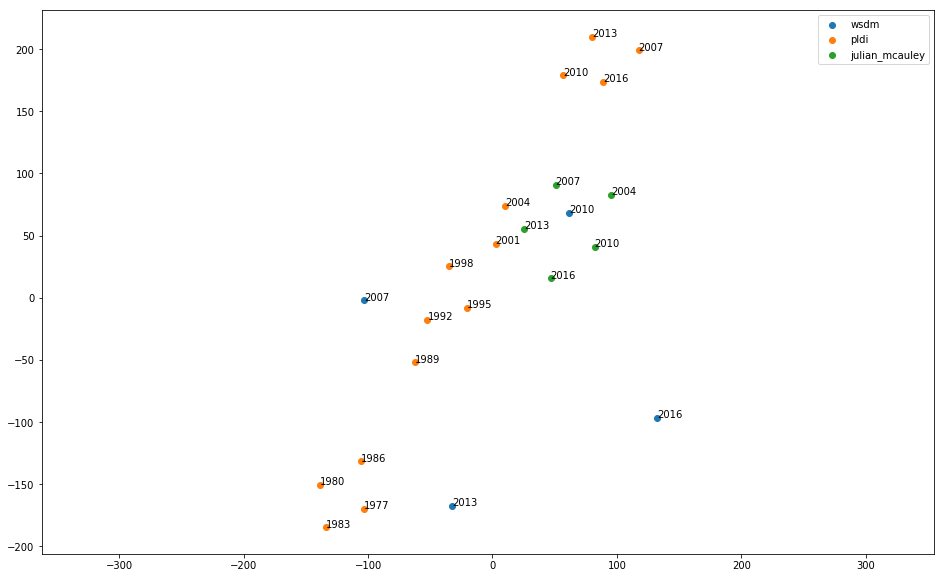

In [141]:
tsne = TSNE(n_components=2, perplexity=4)
year_plot(["wsdm", "pldi", "julian_mcauley"], 3, False, "TSNE")

[1973, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
(43, 2282)
[1979, 1982, 1984, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
(36, 2282)
[2016, 2018, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2010, 2011, 2012, 2013, 2014, 2015]
(21, 2282)


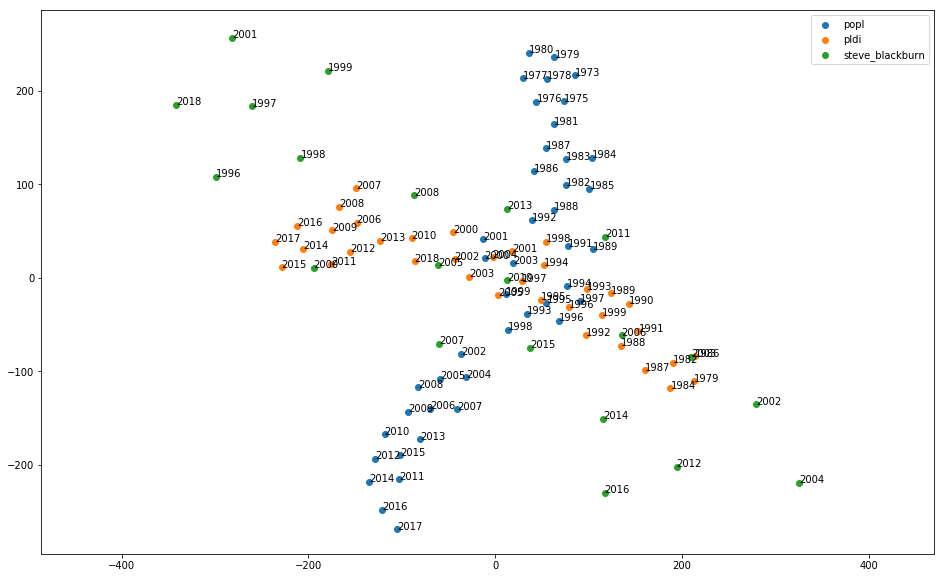

In [131]:
tsne = TSNE(n_components=2, perplexity=10)
year_plot(["popl", "pldi", "steve_blackburn"], 1, True, "TSNE")

[1985, 1990, 1995, 2000, 1970, 2005, 1975, 2010, 1980, 2015]
(10, 2282)
[1985, 1990, 1995, 2000, 2005, 1975, 2010, 1980, 2015]
(9, 2282)
[2000, 2010, 1995, 2005, 2015]
(5, 2282)


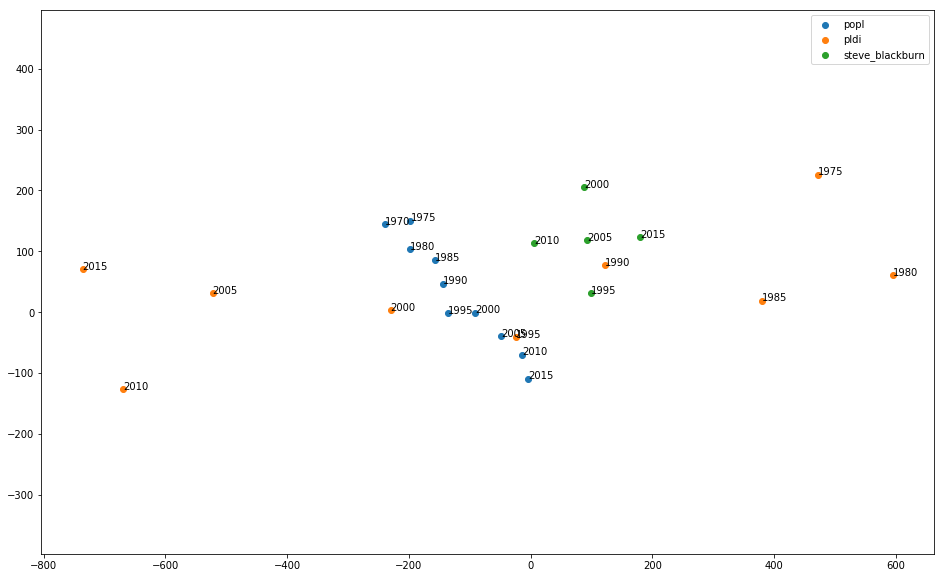

In [142]:
tsne = TSNE(n_components=2, perplexity=4)
year_plot(["popl", "pldi", "steve_blackburn"], 5, True, "TSNE")

[1973, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
(43, 2282)
[1979, 1982, 1984, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
(36, 2282)
[1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
(30, 2282)


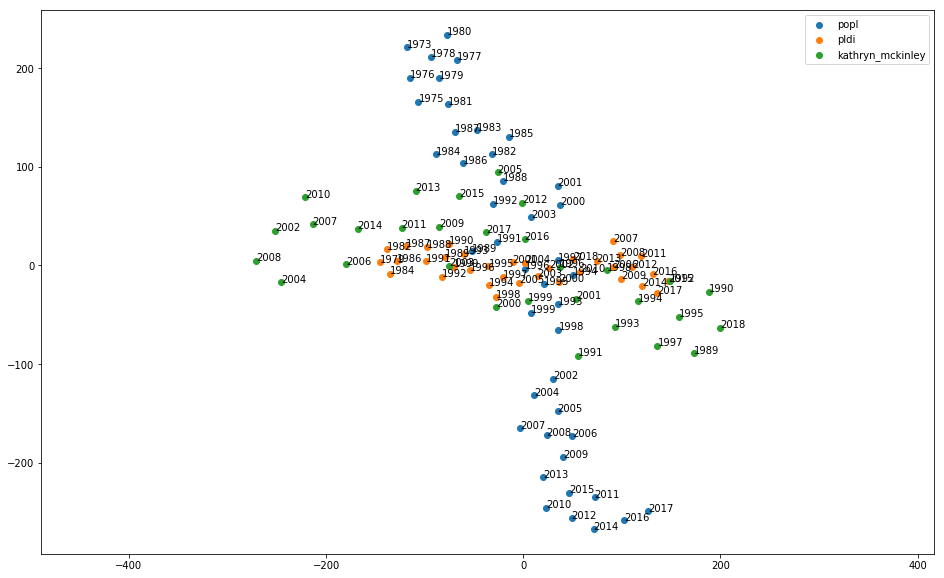

In [148]:
tsne = TSNE(n_components=2, perplexity=10)
year_plot(["popl", "pldi", "kathryn_mckinley"], 1, False, "TSNE")

[2016, 1986, 1989, 1992, 1995, 1998, 2001, 1971, 2004, 1974, 2007, 1977, 2010, 1980, 2013, 1983]
(16, 2282)
[2016, 1986, 1989, 1992, 1995, 1998, 2001, 2004, 2007, 1977, 2010, 1980, 2013, 1983]
(14, 2282)
[2016, 2010, 2013, 2007]
(4, 2282)
[2016, 2010, 2004, 2013, 2007]
(5, 2282)


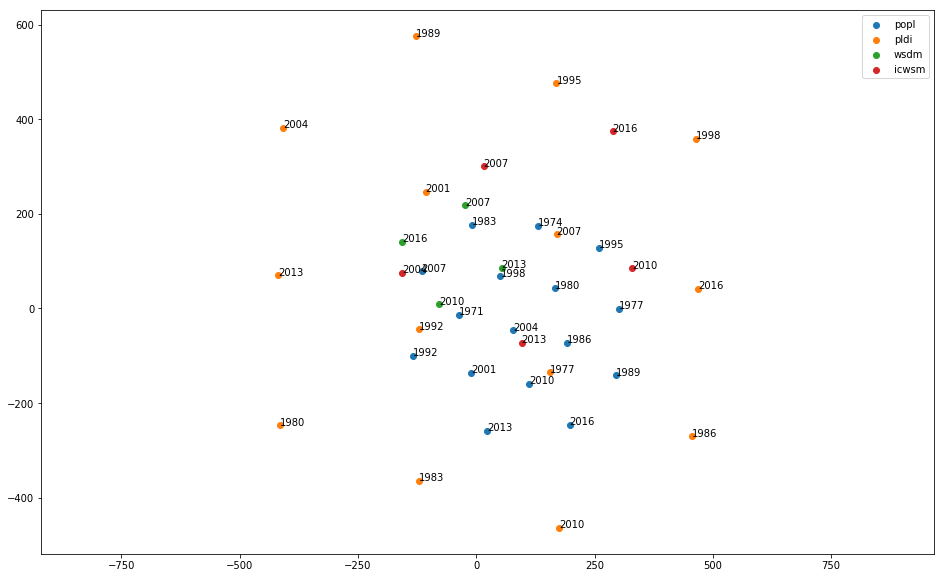

In [61]:
year_plot(["popl", "pldi", "wsdm", "icwsm"], 3, False, "TSNE")

[1973, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
(43, 2282)
[1979, 1982, 1984, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
(36, 2282)
[2016, 2017, 2018, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
(11, 2282)
[2016, 2017, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
(12, 2282)


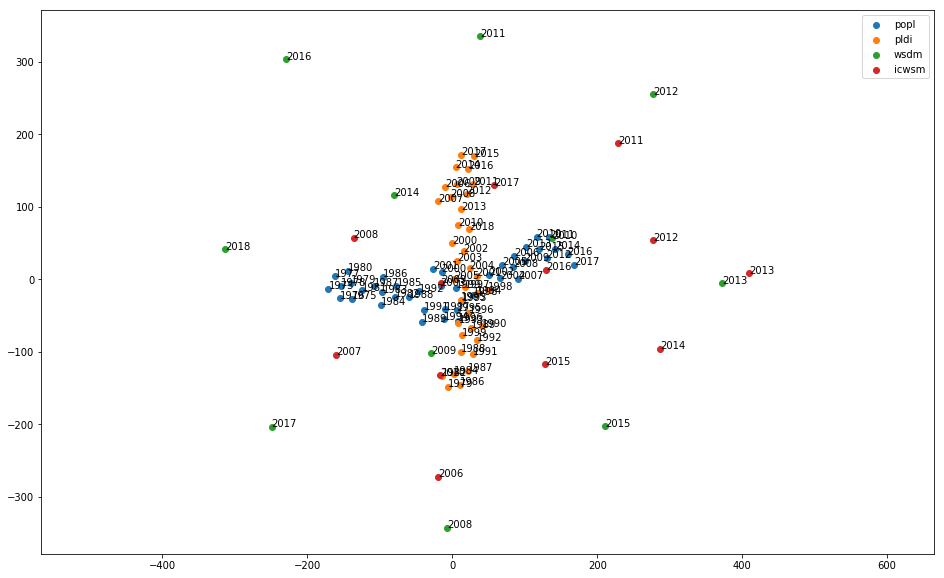

In [151]:
tsne = TSNE(n_components=2, perplexity=10)
year_plot(["popl", "pldi", "wsdm", "icwsm"], 1, False, "TSNE")

[1973, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
(43, 2282)
[1979, 1982, 1984, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
(36, 2282)
[2016, 2017, 2018, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
(11, 2282)
[2016, 2017, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
(12, 2282)


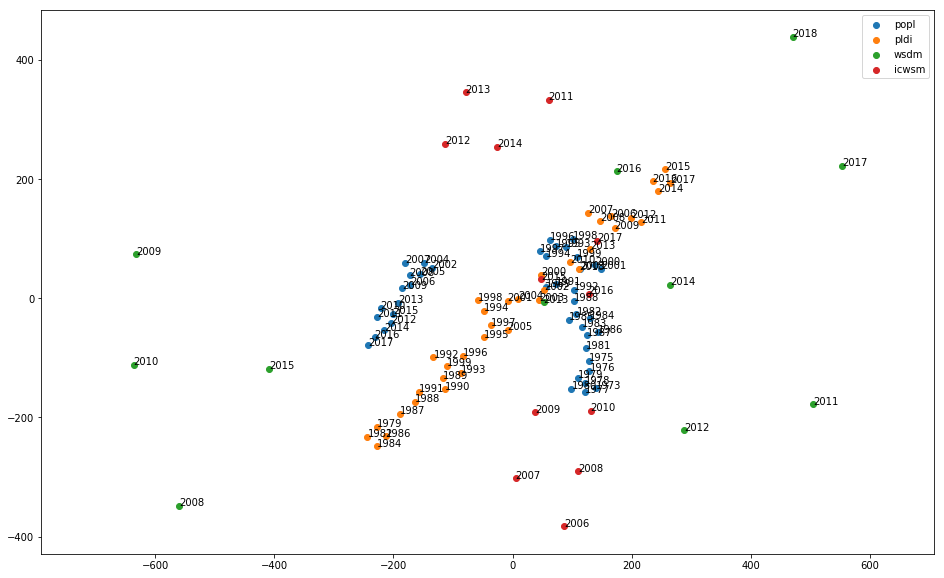

In [158]:
tsne = TSNE(n_components=2, perplexity=5)
year_plot(["popl", "pldi", "wsdm", "icwsm"], 1, False, "TSNE")

[2016, 1986, 1989, 1992, 1995, 1998, 2001, 1971, 2004, 1974, 2007, 1977, 2010, 1980, 2013, 1983]
(16, 2282)
[2016, 1986, 1989, 1992, 1995, 1998, 2001, 2004, 2007, 1977, 2010, 1980, 2013, 1983]
(14, 2282)
[2016, 2010, 2013, 2007]
(4, 2282)
[2016, 2010, 2004, 2013, 2007]
(5, 2282)


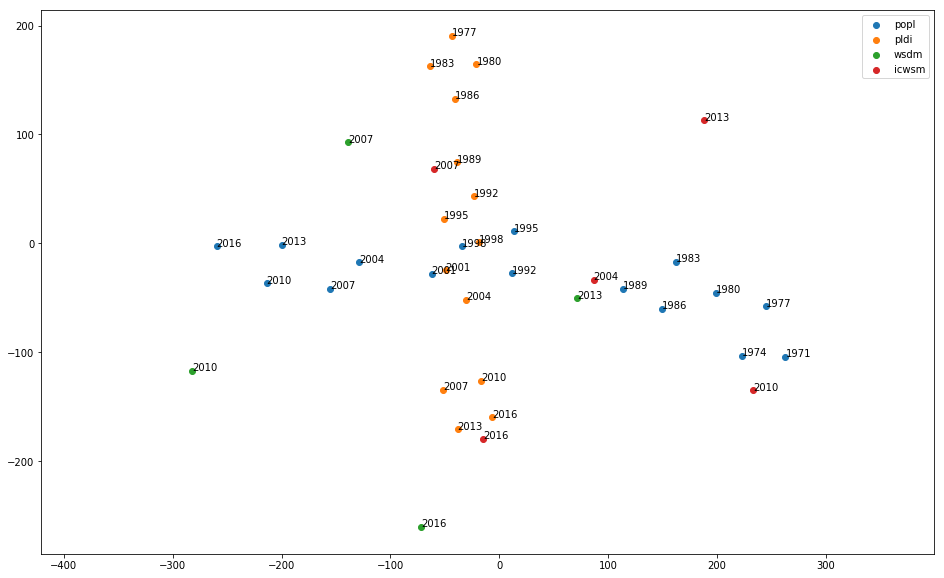

In [159]:
tsne = TSNE(n_components=2, perplexity=5)
year_plot(["popl", "pldi", "wsdm", "icwsm"], 3, True, "TSNE")